# Half-Edge

Az eddigiektől eltérően, ebben a jegyzetben egyetlen új görbe- vagy felülettípus sem fog bemutatásra kerülni. Helyette inkább a *Half-Edge* nevű adatszerkezettel fogunk megismerkedni, ami nagy hasznunkra lesz a különböző subdivision-felületek megvalósításánál.

## Miért van szükség egy új adatszerkezetre?

Korábbi, elsősorban grafikával kapcsolatos tanulmányai során már bizonyára mindenki szembenézett azzal a feladattal, hogy valamilyen poligon mesht, például egy kockát kellett megfelelő adatszerkezettel reprezentálnia. Ismétlésképpen, még a Half-Edge színre lépése előtt, az egyszerűtől a bonyolultabb felé haladva, nézzük meg, milyen módszerek állnak a rendelkezésünkre! 

> A jegyzet további részében **C++** nyelvű példakódok illusztrálják a különböző módszerek és eljárások lényegét.

> Mutatók helyett mindenütt használhatunk indexeket is, melyek egy adott komponens megfelelő listában elfoglalt helyét adják meg.

### Explicit reprezentáció

A legnaivabb megoldás egy mesh tárolására egyetlen lista használata, mely a lapokat tárolja. Az egyes lapokat olyan struktúráknak feleltetjük meg, melyek a lapokat alkotó csúcsokat tartalmazzák. Egy csúcsot, ha több lapnak is része, annyiszor tárolunk el, ahány lapban szerepet játszik.

~~~~~C
struct Vertex {
  float x, y, z;
};

struct Face {
  Vertex *vertices;
};

Face *face_list;
~~~~~

### Mutatók a csúcslistába

Helytakarékosabb megoldás a laplista mellett egy csúcslista alkalmazása. Ebben az esetben a lapok csak az őket alkotó csúcsokra mutató pointerekből állnak, így kiküszöbölve a csúcsok többszöri tárolását.

~~~~ C
struct Vertex {
  float x, y, z;
};

struct Face {
  Vertex **vertices; // Vertex pointerek tömbje
};

Vertex *vertex_list;
Face *face_list;
~~~~

Ennek (és a megelőző adatszerkezetnek is) a legnagyobb hátránya, hogy lehetetlenné teszi a mesh hatékony bejárását. Például nem vagyunk képesek egyszerűen megkeresni egy lap vagy egy csúcs szomszédait. Emellett a dinamikus memóriakezelés jelentette kényelmetlenséggel is meg kell küzdenünk. Ha az egyes lapok különböző számú csúcsból állnak, akkor dinamikus tömbökben (vagy láncolt listákban) kell számon tartanunk a lapot alkotó csúcsokat. 

Ezen okokból kifolyólag ez a reprezentáció nem lesz alkalmas összetett manipulációk támogatására.

### Mutatók az éllistába

A lapok és a csúcsok mellett vezessük be egy újabb komponens, a csúcsok között futó irányítatlan élek kezelését! Így már három típusunk és három listánk lesz:

~~~~ C
struct Vertex {
  float x, y, z;
};

struct Edge {
  Vertex *v1, *v2;
  Face *f1, *f2;
};

struct Face {
  Edge **edges; // Edge mutatók tömbje
};

Vertex *vertex_list;
Edge *edge_list;
Face *face_list;
~~~~

Minden él esetén mutatókat tárolunk arra a két csúcsra, amelyeket az él összeköt (`v1`, `v2`), valamint mutatókat arra a két lapra (`f1`, `f2`), amelyek a az él mentén fekszenek. Előfordulhat, hogy egy élt több mint két lap határol, de ettől az esettől most eltekintünk. A lapok az őket határoló élekre tartalmaznak mutatókat a körüljárás előre rögzített sorrendjének megfelelően.

Miért lesz előnytelen ez az adatszerkezet? Bár a *mutatók a csúcslistába* adatszerkezetnél felmerült kérdésekre egyszerűen választ tudunk adni, továbbra is lesznek olyan feladatok, melyeket nem tudunk kényelmesen megoldani. Ilyenek például a következőek:

  * Mely lapokban játszik szerepet egy adott csúcs?
  * Mely élek futnak ki egy adott csúcsból? 
  
Bár lineáris időben meg tudjuk adni a választ e kérdésekre, gyakran teljes keresést kell végeznünk valamelyik lista elemei között, ami nagyméretű meshek esetén gondot okozhat.

## A Half-Edge adatszerkezet

Már a legutóbbi reprezentációnál is feltűnhetett, hogy az adatszerkezet legfontosabb komponense az éleket leíró típus volt. A Half-Edge is hasonló koncepcióra épít, azonban élek helyett úgynevezett féléleket tárol. Minden olyan irányítatlan élből, melyet két lap határol, két új félél keletkezik, melyek egymás párjai lesznek. Ha az eredeti él a $V_1$ és $V_2$ csúcsok között futott, akkor az egyik új félél a $V_1$-ből fog tartani a $V_2$-be, a másik pedig éppen ellenkezőleg. A két félél közül az egyik az eredeti él egyik oldalán fekvő lapra fog kerülni, a másik a másikra.

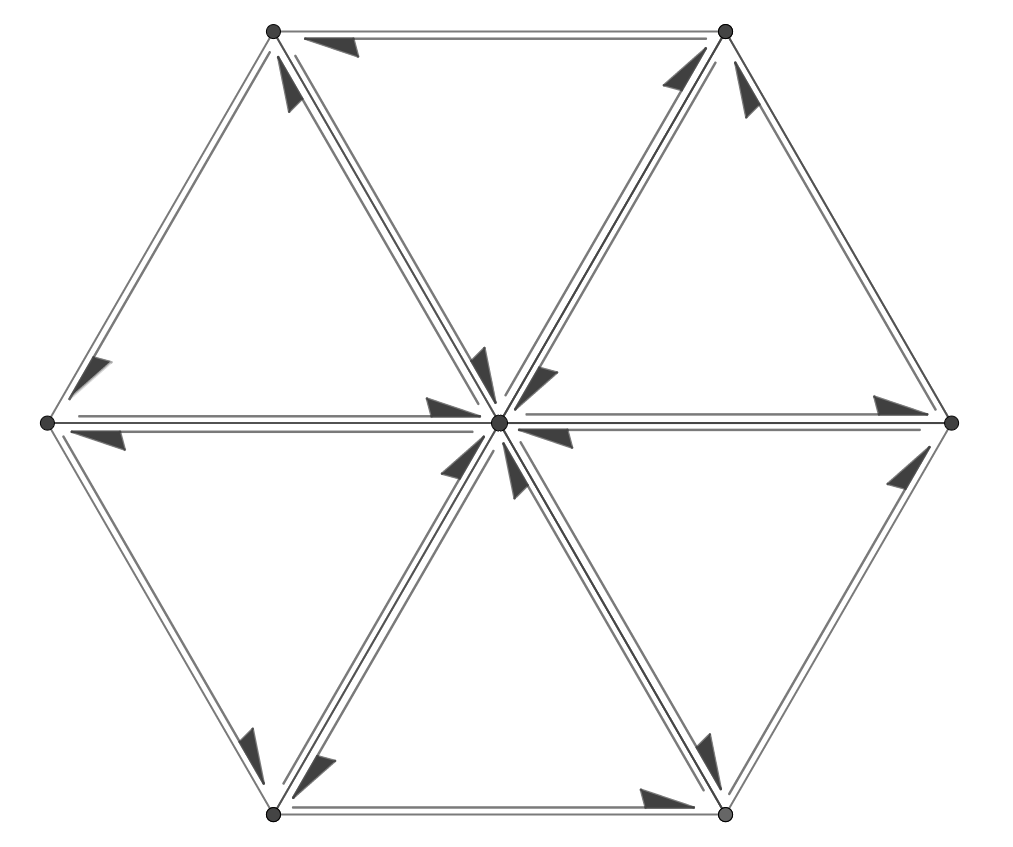

Az azonos élből létrehozott félélek egymás párjai lesznek, egy ennek megefelelő mutatóval. Ez fogja lehetővé tenni, hogy az élek mentén átugorjunk egyik szomszédos lapról a másikra. Minden félél tárol egy mutatót a rákövetkezőjére is. E módon az egy lapon fekvő félélek egy láncolt listába lesznek szervezve, mely körbeér: az utolsó elemének a rákövetkezője az első eleme.

> Kiemelt gondot fordítsunk a lapok körüljárási irányának konzisztenciájára! Azaz, ha az egyik lapot alkotó félélek az óramutató járásának megfelelően vannak láncolt listába szervezve, akkor tartsuk ezt a konvenciót a többi lap esetén is. Ellenkező esetben használhatatlanná válik az adatszerkezet.

Az előző mezők csak a félélek között teremtenek kapcsolatot. Ahhoz, hogy a félélek igazán hasznosak legyenek, még további két mező szükséges. Az egyik arra a lapra fog mutatni, amelyen az adott félél fekszik, a másik pedig arra a csúcsra, amelybe a félél fut.

~~~~C
struct HalfEdge {
  HalfEdge *pair; // a félél párja, azaz egy olyan félél, ami ellentétes irányba mutat,
                  //  és az eredeti élt határoló másik lapon fekszik
                  
  HalfEdge *next; // a félél rákövetkezője az adott lapon
  
  Face *face;     // a lap, amin a félél fekszik
  Vertex *vertex; // a csúcs, amibe a félél mutat
};
~~~~

Annak köszönhetően, hogy a félélek ilyen sok információt tartalmaznak, igazi ragasztóként fognak szolgálni, leegyszerűsítve a többi típust, és rendkívül hatékony bejárást biztosítva. 

A csúcsokat reprezentáló `Vertex` típus a megfelelő koordinátákon túl csak egy pointerből áll, mely egy félélt azonosít. Ez bármely, az adott csúcsba futó (vagy éppen onnan kiinduló, ez megegyezés kérdése) félél lehet.

~~~~C
struct Vertex {
  float x, y, z;
  HalfEdge *edge; // az adott csúcsba futó/onnan kiinduló félél
};
~~~~

Végül, a lapoknak megfeleltetett `Face` típus csak egyetlen mutatót foglal magában, ami egy tetszőleges, a lapon fekvő félél memóriacímét tartalmazza. 

~~~~C
struct Face {
  HalfEdge *edge; // egy tetszőleges, a lapot határoló félél
}
~~~~

Az említetteken felül mindegyik típus tartalmazhat további mezőket is (normálvektorok, színek, stb.), a felsoroltak csak a minimálisan szükségesek. Gyakran eltárolják minden félél megelőzőjét is, ily módon kétirányban láncolt listát képezve.

## Half-Edge Cookbook

Miért olyan erőteljes a Half-Edge? Erre a kérdésre próbál válaszolni a következő kis *cookbook*, bemutatva a leggyakoribb feladatok megoldását.

### Félél végpontjai, szomszédos lapjai

Egy `h` félél birtokában triviális a végpontjainak megkeresése. Az egyik az a csúcs, amibe `h` fut, a másik pedig a párjának a végpontja, azaz

~~~~ C
  Vertex *vertex1 = h->vertex;
  Vertex *vertex2 = h->pair->vertex;
~~~~

Azt a két lapot, melynek határán `h` fekszik, hasonló módon kereshetjük meg:

~~~~ C
  Face *face1 = h->face;
  Face *face2 = h->pair->face;
~~~~

### Lap összes félélének bejárása (*circulating*)

A feladat, hogy járjuk be az összes, az `f` lapon fekvő félélt.

~~~~C
HalfEdge *edge = f->edge;

do {
  // végezzünk valamilyen műveletet az edge féléllel
  
  edge = edge->next;
} while(edge != f->edge);
~~~~

Tehát csak annyit teszünk, hogy végigmegyünk a lapo határoló összes félélen, mindaddig, amíg vissza nem jutunk ahhoz, amelyiktől indultunk. Ebben a `next` mutatók vannak a segítségünkre. Ez a *circulating*nek nevezett művelet lehetővé teszi egy lap összes csúcsának bejárást, összes szomszédos lapjának megkeresését, és így tovább.

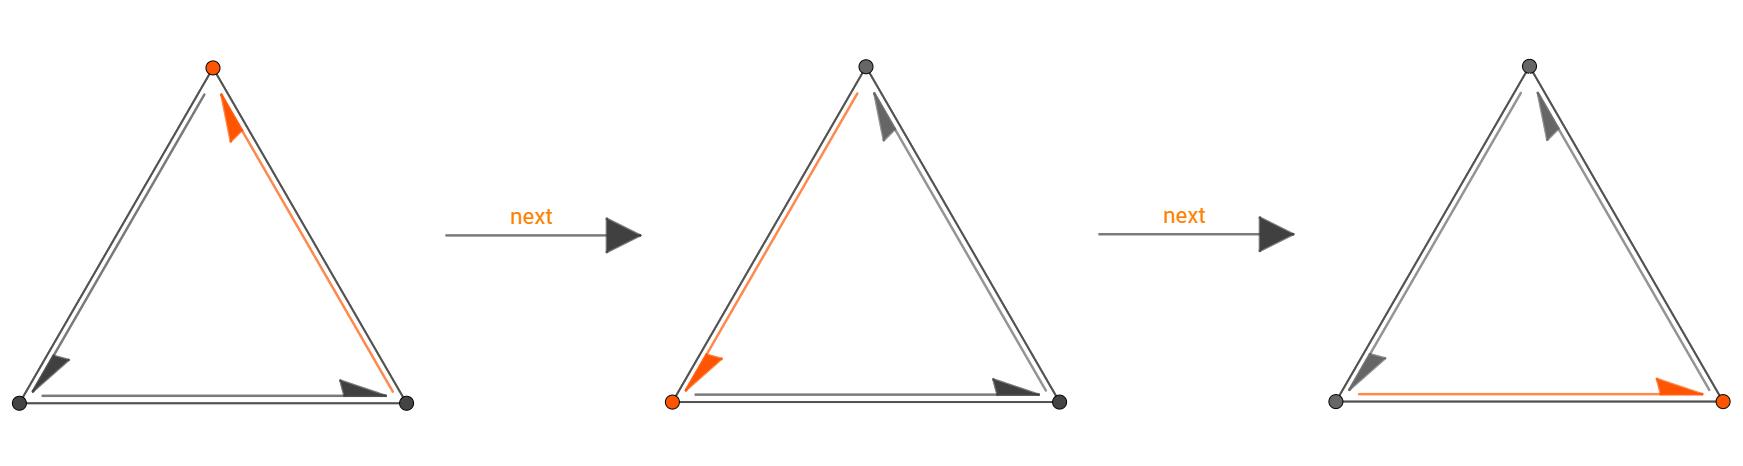

### Csúcs összes szomszédos csúcsának bejárása

Ezúttal a feladatunk, hogy megkeressük egy adott `v` csúcs esetén az összes olyan csúcsot, amelyet él köt össze `v`-vel. `v->edge` legyen most a `v`-be mutató félél.

~~~~C
HalfEdge *edge = v->edge->next;

do {
  // végezzünk valamilyen műveletet az edge->vertex csúccsal
  
  edge = edge->pair->next;
} while (edge->pair != v->edge);
~~~~

Ezzel egyúttal az összes olyan lapot is megkereshetjük, amiben az adott csúcs szerepel.

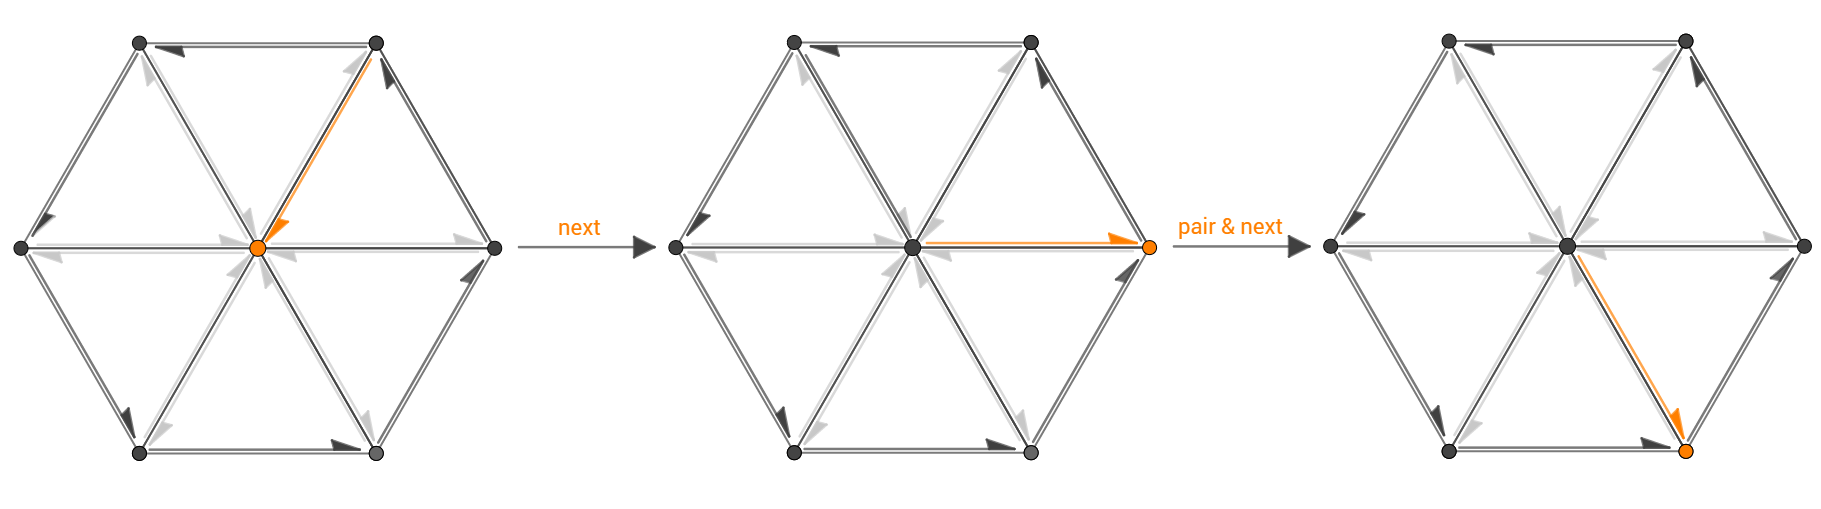

Az ábra baloldalán a kiinduló állapotot láthatjuk, narancssárgával kiemelve a csúcsot, melynek a szomszédjait keressük. Közepén az inicializáció utáni állapot szerepel, az egy, az adott csúcsból kiinduló félél van kiválasztva. Ezt követi az iterációs lépés, a lapok közötti ugrás, melyet addig folyatunk, amíg körbe nem érünk.

## Források

  * Schwarcz Tibor (2005). *Bevezetés a számítógépi grafikába*. pp 73-75., https://gyires.inf.unideb.hu/mobiDiak/Schwarcz-Tibor/Bevezetes-a-szamitogepi-grafikaba/bevgraf.pdf
  * M. McGuire (2000). *The Half-Edge Data Structure* http://www.sccg.sk/~samuelcik/dgs/half_edge.pdf
  * OpenMesh: *The Halfedge Data Structure* https://www.openmesh.org/Daily-Builds/Doc/a00016.html

In [1]:
from IPython.core.display import HTML
def styling():
    styles = open("../../styles/custom.html", "r").read()
    return HTML(styles)
styling()
